In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import sklearn.datasets as datasets

from kviz.visualizer import Visualizer

from importlib.metadata import version
assert version('kviz') == '0.0.11'

TEMPFILE_NAME = "temp.png"

def save_to_gif(filename, images, duration=100):
    images[0].save(
        filename,
        optimize=False,
        save_all=True,
        append_images=images[1:],
        loop=0,
        duration=duration,
    )

np.random.seed(1)

COLORS = np.array(['purple', 'blue'])
cvals  = [0, .5, 1]
colors = ['purple', 'white', 'blue']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

CENTERS = [[0, 0]]
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )

def sigmoid(x):
    e = np.exp(-x)
    return 1 / (1 + e)

# Confidence

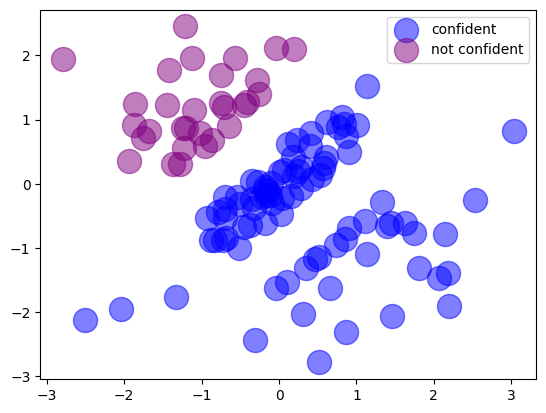

In [9]:
cw1 = -1 
cw2 = 1
cb = -1

sw1 = -1
sw2 = 1
sb = 1

X = np.array(list(filter(lambda x : cw1 * x[0] + cw2 * x[1] + cb < -.5 or cw1 * x[0] + cw2 * x[1] + cb > .5, DATA)))
X = np.array(list(filter(lambda x : sw1 * x[0] + sw2 * x[1] + sb < -.5 or sw1 * x[0] + sw2 * x[1] + sb > .5, X)))
C = np.array([0 if cw1 * x[0] + cw2 * x[1] + cb >= 0 else 1 for x in X])
S = np.array([0 if sw1 * x[0] + sw2 * x[1] + sb >= 0 else 1 for x in X])
conf = X[C==1]
not_conf = X[C==0]
plt.scatter(conf[:,0], conf[:,1], color=COLORS[1], s=300, alpha=.5, label='confident')
plt.scatter(not_conf[:,0], not_conf[:,1], color=COLORS[0], s=300, alpha=.5, label='not confident')
plt.legend()
plt.show()

# Stressed

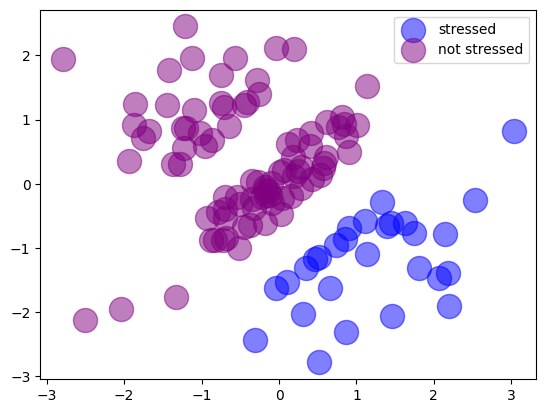

In [10]:
stressed = X[S==1]
not_stressed = X[S==0]
plt.scatter(stressed[:,0], stressed[:,1], color=COLORS[1], s=300, alpha=.5, label='stressed')
plt.scatter(not_stressed[:,0], not_stressed[:,1], color=COLORS[0], s=300, alpha=.5, label='not stressed')
plt.legend()
plt.show()

# Pass / Fail

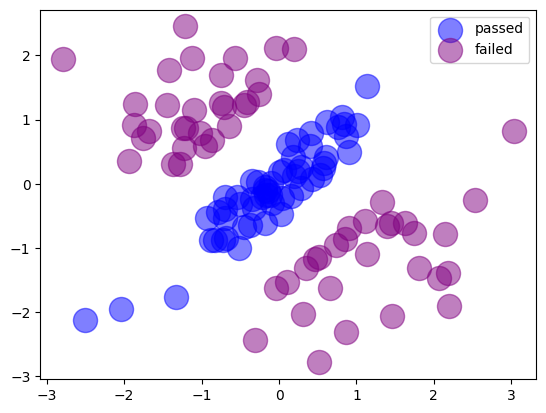

In [11]:
pass_fail = C ^ S
passed = X[pass_fail == 1]
failed = X[pass_fail == 0]
plt.scatter(passed[:,0], passed[:,1], color=COLORS[1], s=300, alpha=.5, label='passed')
plt.scatter(failed[:,0], failed[:,1], color=COLORS[0], s=300, alpha=.5, label='failed')
plt.legend()
plt.show()

# Visualization

In [18]:
from tensorflow.keras.initializers import Zeros

model = keras.models.Sequential()
model.add(keras.layers.Dense(2, input_dim=2, activation="tanh", kernel_initializer=Zeros(), bias_initializer=Zeros()))
model.add(keras.layers.Dense(1, activation="tanh", kernel_initializer=Zeros(), bias_initializer=Zeros()))
model.compile(loss="binary_crossentropy")

for l in model.layers:
        print(l.get_weights())
for i in range(100):
    model.fit(X, C, epochs=1, batch_size=200)
    for l in model.layers:
        print(l.get_weights())

# obj = Visualizer(model)
# obj.fit(X, C, 1, 'pass_fail', 100, epochs=50, batch_size=200)
# obj.view_activations_for(X[pass_fail==1], 'pass_activations', 100)
# obj.view_activations_for(X[pass_fail==0], 'fail_activations', 100)

[array([[0., 0.],
       [0., 0.]], dtype=float32), array([0., 0.], dtype=float32)]
[array([[0.],
       [0.]], dtype=float32), array([0.], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 11.9134
[array([[0., 0.],
       [0., 0.]], dtype=float32), array([0., 0.], dtype=float32)]
[array([[0.],
       [0.]], dtype=float32), array([0.], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.9134
[array([[0., 0.],
       [0., 0.]], dtype=float32), array([0., 0.], dtype=float32)]
[array([[0.],
       [0.]], dtype=float32), array([0.], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.9134
[array([[0., 0.],
       [0., 0.]], dtype=float32), array([0., 0.], dtype=float32)]
[array([[0.],
       [0.]], dtype=float32), array([0.], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.9134
[array([[0., 0.],
       [0., 0.]], dtype=float32), array([0., 0.], dtype=float32)]
[array([[0.],
       [0.]], dtype=float32), array([0.], dtype=float32)]
1/1 ━━

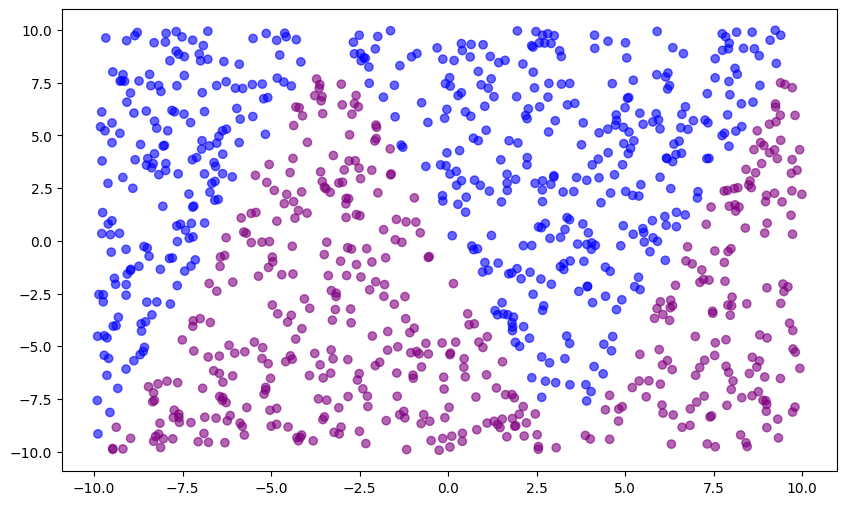

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for the dataset
n_points = 1000  # Total number of points
amplitude = 20    # Amplitude of the zig-zag
frequency = 1.5    # Number of complete zig-zag cycles (3 zigs/zags)

# Generate random (x, y) coordinates within a square
x = np.random.uniform(-10, 10, n_points)
y = np.random.uniform(-10, 10, n_points)

# Combine x and y into a 2D ndarray
data = np.column_stack((x, y))

# Define the zig-zag boundary as a piecewise linear function
def zig_zag_boundary(x):
    y_boundary = np.zeros_like(x)
    segment_length = 20 / (2 * frequency)  # Length of each zig or zag
    for i in range(len(x)):
        segment_index = int((x[i] + 10) // segment_length)
        if segment_index % 2 == 0:  # Even segments slope up
            y_boundary[i] = -10 + (x[i] + 10 - segment_index * segment_length) * (amplitude / segment_length)
        else:  # Odd segments slope down
            y_boundary[i] = 10 - (x[i] + 10 - segment_index * segment_length) * (amplitude / segment_length)
    return y_boundary

# Compute the boundary values
boundary = zig_zag_boundary(x)

# Filter out points close to the decision boundary
threshold = 0.5
mask_boundary = np.abs(y - boundary) > threshold

# Combine both masks
final_mask = mask_boundary
X = data[final_mask]
filtered_x = X[:, 0]
filtered_y = X[:, 1]
Y = (filtered_y > zig_zag_boundary(filtered_x)).astype(int)

# Plot the filtered dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=COLORS[Y.tolist()], alpha=0.6)
plt.show()


In [79]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(3, input_dim=2, activation="sigmoid"))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-1))

obj = Visualizer(model)
obj.fit(X, Y, 10, '00', 100, epochs=100)

class_1_mask = (filtered_x < -3) & (Y == 1)
class_1_x = filtered_x[class_1_mask]
class_1_y = filtered_y[class_1_mask]

obj.view_activations_for(np.column_stack((class_1_x, class_1_y)), '01', 100)

W = model.layers[0].get_weights()[0]
B = model.layers[0].get_weights()[1]
xlim_min = -10
xlim_max = 10
ylim_min = -10
ylim_max = 10

xx = np.linspace(xlim_min, xlim_max, 300)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color=COLORS[Y].tolist(), alpha=.4)
ax.plot(xx, - W[0][0] * xx / W[1][0] - B[0] /  W[1][0], linestyle='dashed', color='b', label='$w_1x_1 + w_2x_2 + b_1 = 0$')
ax.plot(xx, - W[0][1] * xx / W[1][1] - B[1] /  W[1][1], linestyle='dashed', color='g', label='$w_3x_1 + w_4x_2 + b_2 = 0$')
ax.plot(xx, - W[0][2] * xx / W[1][2] - B[2] /  W[1][2], linestyle='dashed', color='r', label='$w_5x_1 + w_6x_2 + b_3 = 0$')
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.legend(loc='lower right', fontsize=12)

fig.savefig('02.png')
plt.close()

Epoch 1/10
 1/30 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.6522

/Users/lance/Documents/BostonUniversity/Data-Science-Fundamentals/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.5713
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.5211
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 0.4496
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.4034
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - loss: 0.3879
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.3583
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - loss: 0.2648
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - loss: 0.2363
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - loss: 0.1731
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - loss: 0.1414
34224/34224 ━━━━━━━━━━━━━━━━━━━━ 5s 156us/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 0.1440
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 0.1199
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 0.1047
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 0.1100
Epoch 5/10
30/30 ━━━━━━━━

[[0.26100858]
 [0.18814373]
 [0.26100858]]
Negative Log Loss at Initialization =  [0.75849568]


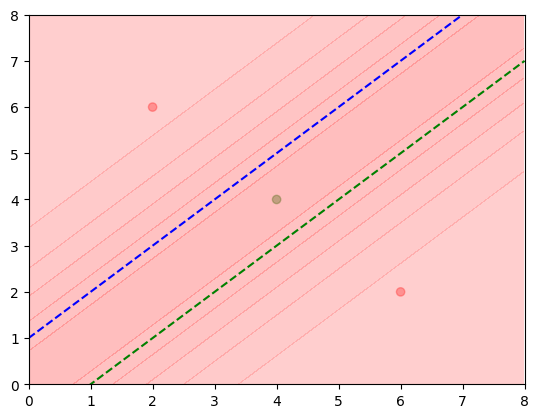

In [565]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

cvals  = [0, .5, 1]
colors = ['red', 'white', 'green']
tuples = list(zip(cvals, colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

X = np.array([[2, 6],
              [4, 4],
              [6, 2]])
Y = np.array([0, 1, 0]).reshape(3, 1)

W1 = np.array([[1, -1], [-1, 1]])
b1 = np.array([1, 1]).reshape(2, 1)
W2 = np.array([[-1, -1]]).reshape(1, 2)
b2 = np.array([0])

learning_rate = 2.0

def sigmoid(x):
    e = np.exp(-x)
    return 1 / (1 + e)

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def h_net(W1, b1, x):
    return np.dot(W1, x.reshape(-1, 1)) + b1

def hidden(W1, b1, x):
    return sigmoid(h_net(W1, b1, x))

def out(W1, W2, b1, b2, x):
    return sigmoid(np.dot(W2, hidden(W1, b1, x)) + b2)

def nll(pred, targ):
    lls = [np.log(1 - p) if t==0 else np.log(p) for p,t in zip(pred, targ)]
    return - sum(lls) / len(lls)

def predict(W1, W2, b1, b2, X):
    return np.array([out(W1, W2, b1, b2, x) for x in X]).flatten().reshape(-1,1)

def plot_db(W1, W2, b1, b2, X):
    xlim_min = 0
    xlim_max = 8
    ylim_min = 0
    ylim_max = 8

    h = .02
    xx, yy = np.meshgrid(np.arange(xlim_min, xlim_max, h),
                        np.arange(ylim_min, ylim_max, h))
    meshData = np.c_[xx.ravel(), yy.ravel()]
    COLORS = np.array(['red', 'green', 'red'])
    xplot = np.linspace(xlim_min, xlim_max, 300)
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], color=COLORS, alpha=.4)
    ax.plot(xplot, - W1[0][0] * xplot / W1[1][0] - b1[0][0] /  W1[1][0], linestyle='dashed', color='b', label='$w_{00}x_1 + w_{01}x_2 + b_1 = 0$')
    ax.plot(xplot, - W1[0][1] * xplot / W1[1][1] - b1[1][0] /  W1[1][1], linestyle='dashed', color='g', label='$w_{10}x_1 + w_{11}x_2 + b_2 = 0$')
    Z = predict(W1, W2, b1, b2, meshData).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.4, cmap=CMAP, vmin=0, vmax=1)

    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    plt.show()

def step(W1, W2, b1, b2, X, Y):
    pred = predict(W1, W2, b1, b2, X)

    grad_W1 = - (1 / len(X)) * sum([(y - p) * W2.T * np.dot(sigmoid_grad(h_net(W1, b1, x)).reshape(2, 1), x.reshape(1, 2)) for x,y,p in zip(X, Y, pred)])
    assert grad_W1.shape == W1.shape
    grad_W2 = - (1 / len(X)) * sum([hidden(W1, b1, x).T*(y - p) for x,y,p in zip(X, Y, pred)])
    assert grad_W2.shape == W2.shape
    W1 = W1 - learning_rate * grad_W1
    W2 = W2 - learning_rate * grad_W2
    
    grad_b1 = - (1 / len(X)) * sum([(y - p) * W2.T * sigmoid_grad(h_net(W1, b1, x)).reshape(2, 1) for x,y,p in zip(X, Y, pred)])
    assert grad_b1.shape == b1.shape
    grad_b2 = - (1 / len(X)) * sum([(y - p) for y,p in zip(Y, pred)])
    assert grad_b2.shape == b2.shape

    b1 = b1 - learning_rate * grad_b1
    b2 = b2 - learning_rate * grad_b2

    return W1, W2, b1, b2

pred = predict(W1, W2, b1, b2, X)
print(pred)
print("Negative Log Loss at Initialization = ", nll(pred, Y))
plot_db(W1, W2, b1, b2, X)
count = 1

[[ 0.59700778 -1.37617543]
 [-1.37617543  0.59700778]] [[-0.78541717 -0.78541717]] [[0.97582001]
 [0.97582001]] [0.19322607]
[[0.38152383]
 [0.50699732]
 [0.38152383]]
Negative Log Loss after 2 step =  [0.5467476]
[[0.27936041 0.27985691 0.28036665 ... 0.35671495 0.35670819 0.3567015 ]
 [0.27985691 0.2803446  0.28084557 ... 0.3567313  0.35672434 0.35671747]
 [0.28036665 0.28084557 0.2813378  ... 0.3567481  0.35674095 0.35673388]
 ...
 [0.35671495 0.3567313  0.3567481  ... 0.54604414 0.54606005 0.54607505]
 [0.35670819 0.35672434 0.35674095 ... 0.54606005 0.54607664 0.54609231]
 [0.3567015  0.35671747 0.35673388 ... 0.54607505 0.54609231 0.54610865]]


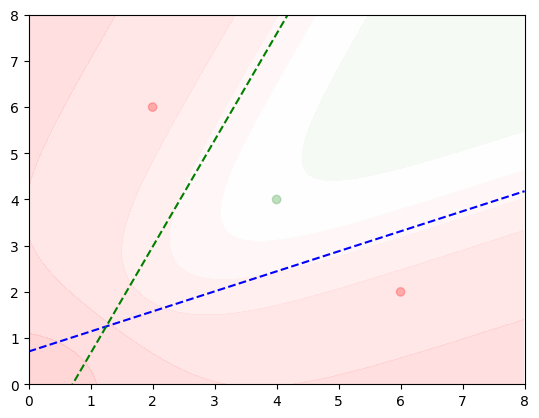

In [564]:
count += 1
W1, W2, b1, b2 = step(W1, W2, b1, b2, X, Y)
print(W1, W2, b1, b2)
pred = predict(W1, W2, b1, b2, X)
print(pred)
print("Negative Log Loss after " + str(count) + " step = ", nll(pred, Y))
plot_db(W1, W2, b1, b2, X)

[[ 1.28483791 -2.5867894 ]
 [-2.49430143  1.41676129]] [[-3.73053751 -3.74120774]] [[ 0.91808871]
 [-0.02562849]] [1.31900309]
Negative Log Loss after 34 step =  [0.14966147]


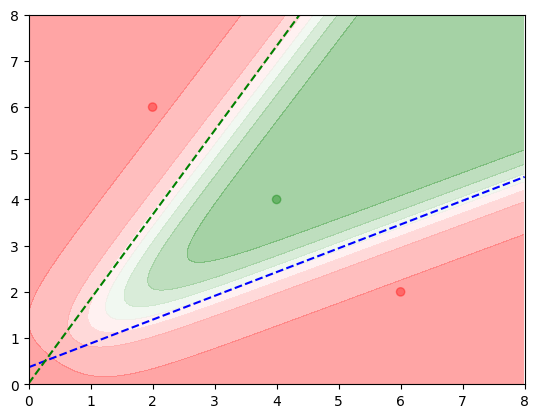

In [539]:
count += 1
W1, W2, b1, b2 = step(W1, W2, b1, b2, X, Y)
print(W1, W2, b1, b2)
print("Negative Log Loss after " + str(count) + " step = ", nll(predict(W1, W2, b1, b2, X), Y))
plot_db(W1, W2, b1, b2, X)

[[ 1.39343195 -0.57620762]
 [-1.44232963  0.59618338]] [[ 0.44850189 -1.07137665]] [[-0.94435822]
 [ 0.93703405]] [-0.61988646]
Negative Log Loss after 4 step =  [0.55828054]


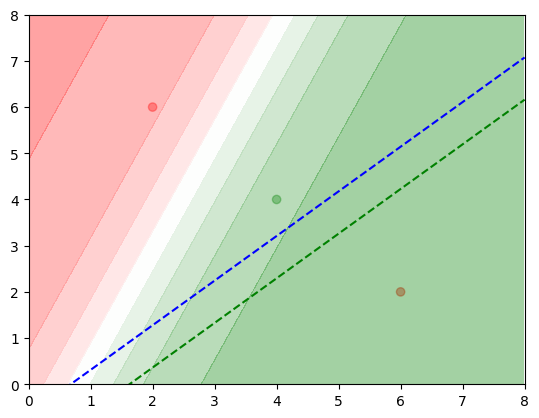

In [427]:
count += 1
W1, W2, b1, b2 = step(W1, W2, b1, b2, X, Y)
print(W1, W2, b1, b2)
print("Negative Log Loss after " + str(count) + " step = ", nll(predict(W1, W2, b1, b2, X), Y))
plot_db(W1, W2, b1, b2, X)

[[ 1.43172855 -0.56854884]
 [-1.5221007   0.58942246]] [[ 0.47181283 -1.14803544]] [[-0.9410338 ]
 [ 0.93631764]] [-0.66947772]
Negative Log Loss after 5 step =  [0.5507172]


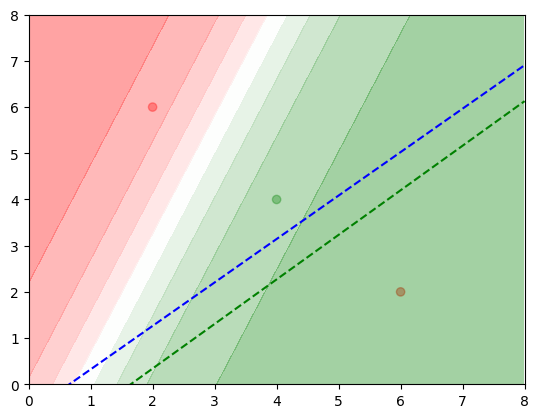

In [428]:
count += 1
W1, W2, b1, b2 = step(W1, W2, b1, b2, X, Y)
print(W1, W2, b1, b2)
print("Negative Log Loss after " + str(count) + " step = ", nll(predict(W1, W2, b1, b2, X), Y))
plot_db(W1, W2, b1, b2, X)

[[ 1.46350597 -0.57016166]
 [-1.57248931  0.62427083]] [[ 0.50392479 -1.22365121]] [[-0.93859767]
 [ 0.93402578]] [-0.70760378]
Negative Log Loss after 6 step =  [0.54445692]


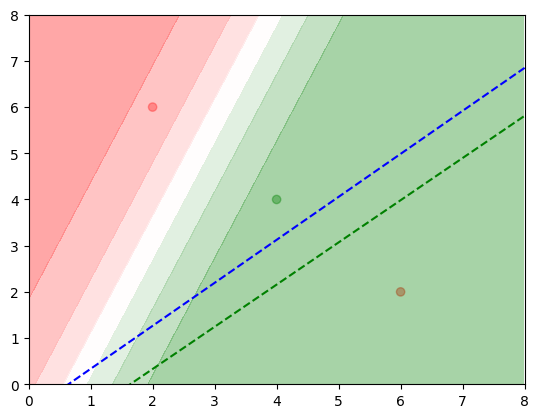

In [429]:
count += 1
W1, W2, b1, b2 = step(W1, W2, b1, b2, X, Y)
print(W1, W2, b1, b2)
print("Negative Log Loss after " + str(count) + " step = ", nll(predict(W1, W2, b1, b2, X), Y))
plot_db(W1, W2, b1, b2, X)

[[ 2.16716685 -0.82959406]
 [-2.59875497  1.10826472]] [[ 1.16289363 -2.61622654]] [[-0.89498337]
 [ 0.88450575]] [-1.19419773]
Negative Log Loss after 45 step =  [0.4784376]


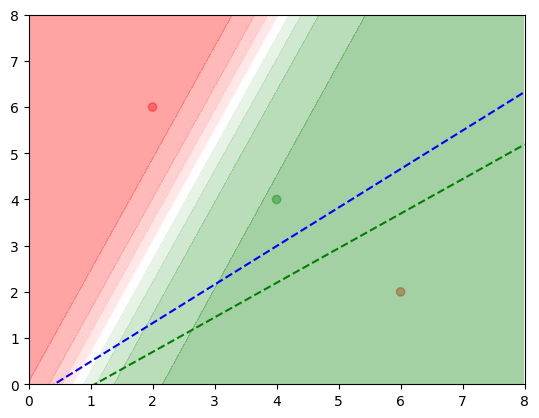

In [468]:
count += 1
W1, W2, b1, b2 = step(W1, W2, b1, b2, X, Y)
print(W1, W2, b1, b2)
print("Negative Log Loss after " + str(count) + " step = ", nll(predict(W1, W2, b1, b2, X), Y))
plot_db(W1, W2, b1, b2, X)